<a href="https://colab.research.google.com/github/jiasheng59/MLusic/blob/main/%5Bgtzan%20features%5D%5BSklearn%20version%5D%20CS3264_Group_Project_(K%20means%20clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.preprocessing import OneHotEncoder

# Importing Data

In [7]:
def get_audio_file_path(genre: str, name: str) -> str:
  """
  Return the relative file path of the audio file.
  """
  return f'{genre}/{genre}.{name}.wav'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

project_root_dir: str = '/content/drive/MyDrive/CS3264/Data/'

csv_data_route: str = 'features_30_sec.csv'
audio_data_route: str = 'genres_original/'

df = pd.read_csv(f'{project_root_dir}{csv_data_route}')
audio_1_filepath = f'{project_root_dir}{audio_data_route}{get_audio_file_path("blues", "00000")}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inspect Data

In [9]:
df.shape

(1000, 60)

In [10]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
df.isnull().any()

filename                   False
length                     False
chroma_stft_mean           False
chroma_stft_var            False
rms_mean                   False
rms_var                    False
spectral_centroid_mean     False
spectral_centroid_var      False
spectral_bandwidth_mean    False
spectral_bandwidth_var     False
rolloff_mean               False
rolloff_var                False
zero_crossing_rate_mean    False
zero_crossing_rate_var     False
harmony_mean               False
harmony_var                False
perceptr_mean              False
perceptr_var               False
tempo                      False
mfcc1_mean                 False
mfcc1_var                  False
mfcc2_mean                 False
mfcc2_var                  False
mfcc3_mean                 False
mfcc3_var                  False
mfcc4_mean                 False
mfcc4_var                  False
mfcc5_mean                 False
mfcc5_var                  False
mfcc6_mean                 False
mfcc6_var 

# K-means Clustering
We are not using the columns that is unlikely to be extracted from an audio file / not really useful to be a feature

Columns ignored: name, length, label(genre)

In [12]:
training_df = df.iloc[:,2:-1]

In [11]:
training_df.columns

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'],
      dtype='object')

In [13]:
kmeans = KMeans(n_init = 'auto').fit(training_df.to_numpy()) # Training

# Extract features from audio

In [14]:
def interleave_arrays(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    interleaved = np.empty(arr1.size + arr2.size, dtype=arr1.dtype)
    interleaved[0::2] = arr1
    interleaved[1::2] = arr2
    return interleaved

In [15]:
def audio_to_dfcols(audio_filepath: str, df_cols: np.ndarray) -> pd.DataFrame:
  y, sr = librosa.load(audio_filepath)

  # duration = librosa.get_duration(y = y, sr = sr)
  chroma_stft_res = librosa.feature.chroma_stft(y = y, sr = sr)
  rms_res = librosa.feature.rms(y = y)
  spectral_centroid_res = librosa.feature.spectral_centroid(y = y, sr = sr)
  spectral_bandwidth_res = librosa.feature.spectral_bandwidth(y = y, sr = sr)
  spectral_rolloff_res = librosa.feature.spectral_rolloff(y = y, sr = sr)
  zero_crossing_rate_res = librosa.feature.zero_crossing_rate(y = y)
  harmonic_res = librosa.effects.harmonic(y)
  percussive_res = librosa.effects.percussive(y)
  tempo = librosa.beat.tempo(y = y, sr = sr)
  mfccs = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 20)
  mfccs_means = np.mean(mfccs, axis = 1)
  mfccs_vars = np.var(mfccs, axis = 1)
  result: np.ndarray = np.concatenate((
    # np.array(duration),
   np.mean(chroma_stft_res), np.var(chroma_stft_res),
   np.mean(rms_res), np.var(rms_res),
   np.mean(spectral_centroid_res), np.var(spectral_centroid_res),
   np.mean(spectral_bandwidth_res), np.var(spectral_bandwidth_res),
   np.mean(spectral_rolloff_res), np.var(spectral_rolloff_res),
   np.mean(zero_crossing_rate_res), np.var(zero_crossing_rate_res),
   np.mean(harmonic_res), np.var(harmonic_res),
   np.mean(percussive_res), np.var(percussive_res),
   np.array(tempo)), axis = None)
  result = np.concatenate((result, interleave_arrays(mfccs_means, mfccs_vars)), axis = None)
  return pd.DataFrame(data = result.reshape(1, -1), columns = df_cols)

In [ ]:
audio_1_df = audio_to_dfcols(audio_1_filepath, df.columns[2:-1].to_numpy())

<ipython-input-5-916e9c98b04c>:13: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y = y, sr = sr)


(57,)
(57,)


In [ ]:
audio_1_df

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350129,0.088772,0.130184,0.002828,1784.122641,129745.484419,2002.412407,85834.410406,3805.72303,901252.916706,...,0.751706,52.424534,-1.687854,36.535866,-0.40873,41.603172,-2.302677,55.053654,1.222467,46.941349


In [ ]:
df.head(1).iloc[:,2:-1]

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,2002.44906,85882.761315,3805.839606,901505.425533,...,0.75274,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035


# Predict the cluster of given audio and provide recommendation

In [31]:
def predict_and_update(input_audio_path: str, training_df: pd.DataFrame, n: int) -> pd.DataFrame:
  """
  Output all the datas that have the same label as the given input.
  Note that the input will not be stored into the data set.
  """
  features = audio_to_dfcols(input_audio_path, training_df.columns)
  kmeans = KMeans(n_init = 'auto').fit(training_df.to_numpy())
  filtered = df[kmeans.labels_ == kmeans.predict(features.to_numpy())]
  return filtered.sample(n = min(n, len(filtered)))

In [33]:
predict_and_update(audio_1_filepath, training_df, 5)

<ipython-input-15-a40f60b5ccb8>:13: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y = y, sr = sr)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
369,disco.00069.wav,661504,0.389193,0.082729,0.111631,0.001731,1931.082069,188567.674409,2209.150997,43228.108244,...,29.582720,-7.945790,28.254889,3.666682,34.077782,-6.156417,35.428486,2.696897,33.346764,disco
495,hiphop.00095.wav,661794,0.562447,0.067982,0.103468,0.001790,2735.775141,279951.096596,2295.702995,50878.502151,...,38.174522,-2.969538,43.560001,3.700952,35.976475,-5.405601,34.310566,-4.211085,34.002029,hiphop
922,rock.00022.wav,661794,0.415770,0.078892,0.173919,0.002272,2342.440836,256754.458502,2113.038593,71777.331607,...,53.345806,-7.464095,39.981232,2.070638,57.735928,-2.897590,40.805145,-0.363278,38.174831,rock
352,disco.00052.wav,661504,0.416318,0.078338,0.125366,0.002007,2590.650686,256436.829239,2162.799226,67058.366744,...,40.199726,-7.877803,38.889751,-0.641498,45.699696,-4.364861,41.651104,0.195190,45.512287,disco
953,rock.00053.wav,661794,0.409181,0.074969,0.190228,0.001885,3361.723252,304156.952322,2933.069563,55087.671460,...,32.352867,-3.010583,30.043829,-1.713658,34.125484,-1.694629,29.735903,-1.296358,41.978283,rock


# Evaluating different model using silhouette score

In [26]:
def eval_model(clusterer, n_clusters = None):
    X = training_df

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters == None:
      n_clusters = len(np.unique(clusterer.labels_))
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 'auto')

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
'''
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
'''

'\n    # 2nd Plot showing the actual clusters formed\n    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)\n    ax2.scatter(\n        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"\n    )\n\n    # Labeling the clusters\n    centers = clusterer.cluster_centers_\n    # Draw white circles at cluster centers\n    ax2.scatter(\n        centers[:, 0],\n        centers[:, 1],\n        marker="o",\n        c="white",\n        alpha=1,\n        s=200,\n        edgecolor="k",\n    )\n\n    for i, c in enumerate(centers):\n        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")\n\n    ax2.set_title("The visualization of the clustered data.")\n    ax2.set_xlabel("Feature space for the 1st feature")\n    ax2.set_ylabel("Feature space for the 2nd feature")\n\n    plt.suptitle(\n        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"\n        % n_clusters,\n        fontsize=14,\n        fontweig

For n_clusters = 2 The average silhouette_score is : 0.6287962007796959
For n_clusters = 3 The average silhouette_score is : 0.550533318298231
For n_clusters = 4 The average silhouette_score is : 0.5319479278195725
For n_clusters = 5 The average silhouette_score is : 0.5091290886206066
For n_clusters = 6 The average silhouette_score is : 0.4578459339791737
For n_clusters = 7 The average silhouette_score is : 0.45650018334796366
For n_clusters = 8 The average silhouette_score is : 0.45754713369764805
For n_clusters = 9 The average silhouette_score is : 0.45758603824507293
For n_clusters = 10 The average silhouette_score is : 0.43379458974869045
For n_clusters = 11 The average silhouette_score is : 0.413749776277542
For n_clusters = 12 The average silhouette_score is : 0.4051616368194552
For n_clusters = 13 The average silhouette_score is : 0.40197931599912756
For n_clusters = 14 The average silhouette_score is : 0.4151000763519162
For n_clusters = 15 The average silhouette_score is : 0.

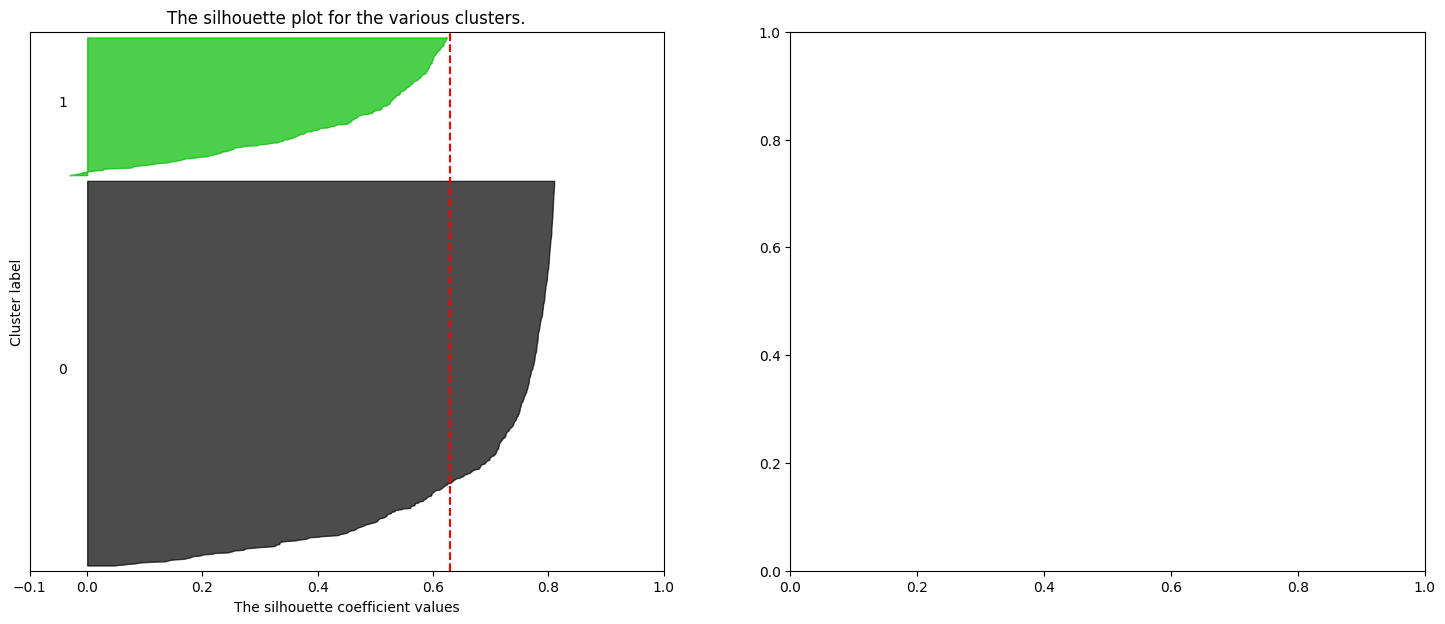

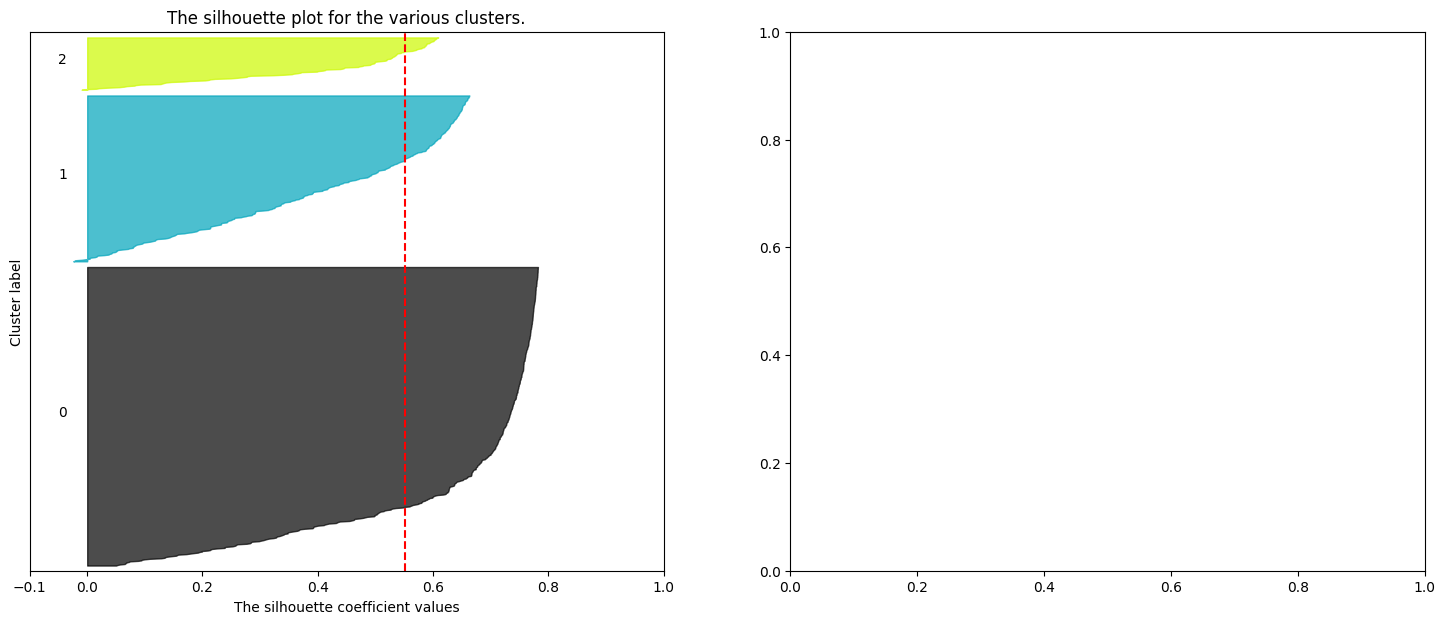

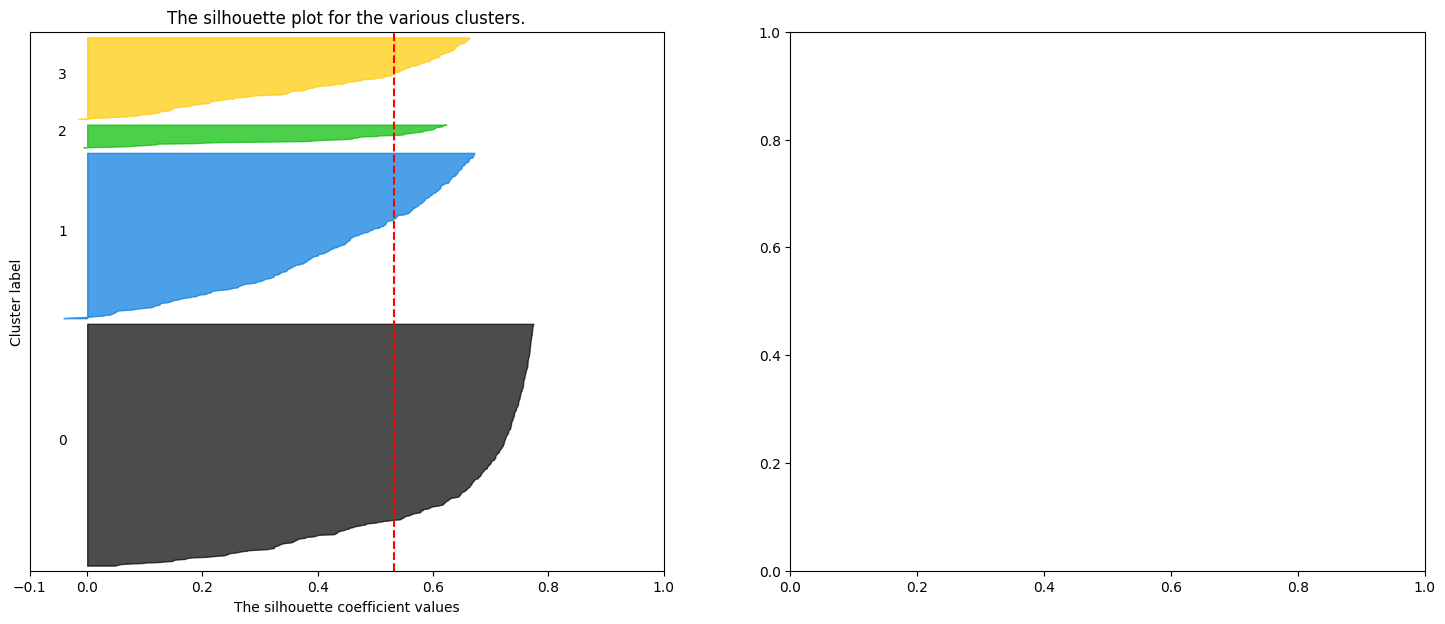

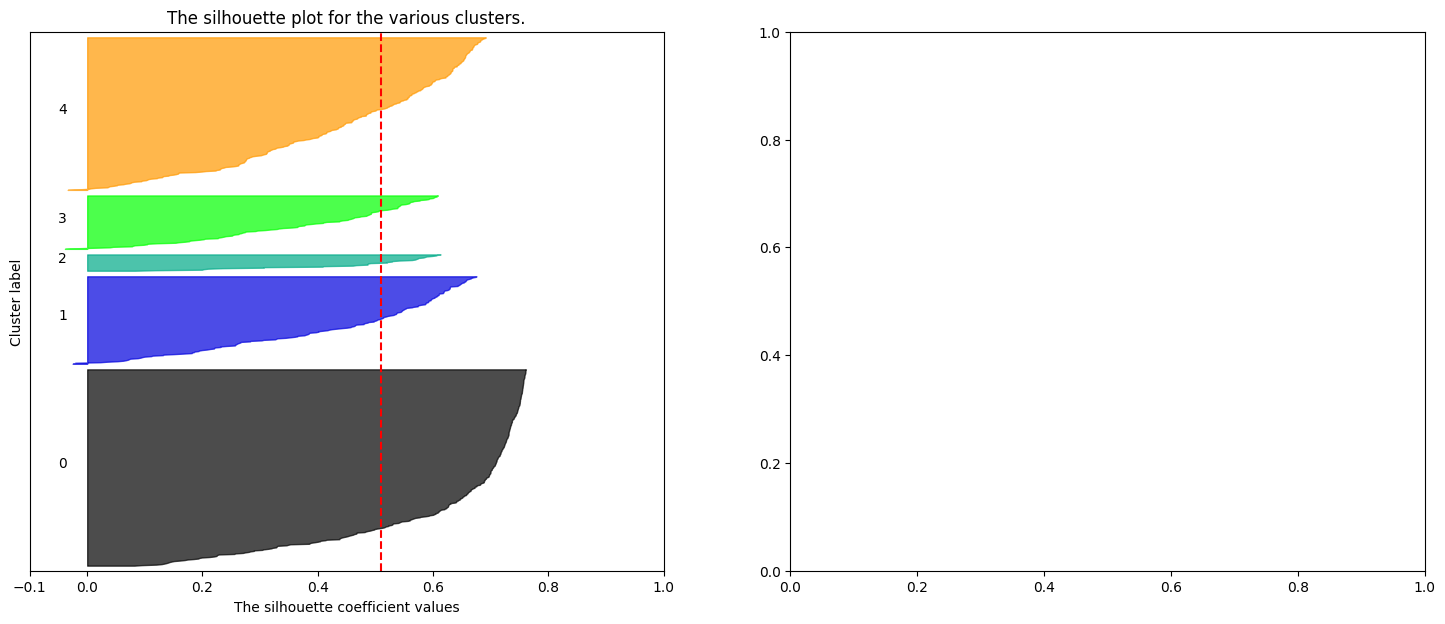

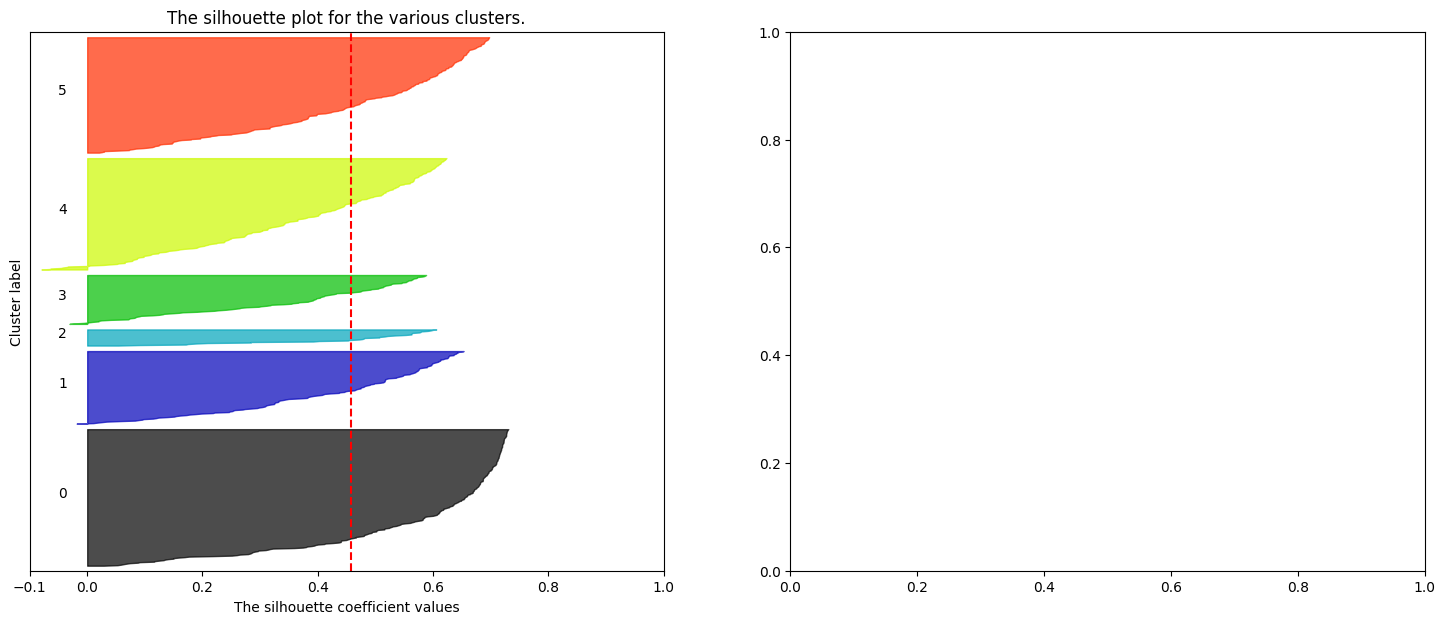

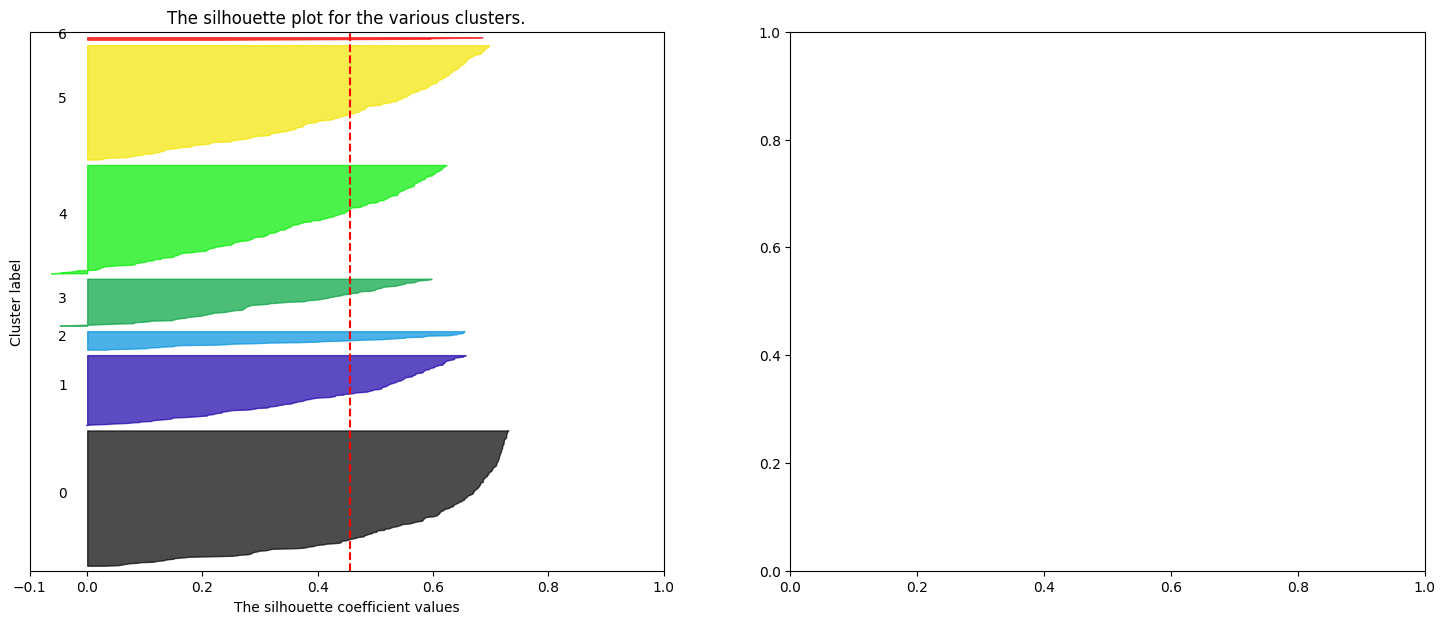

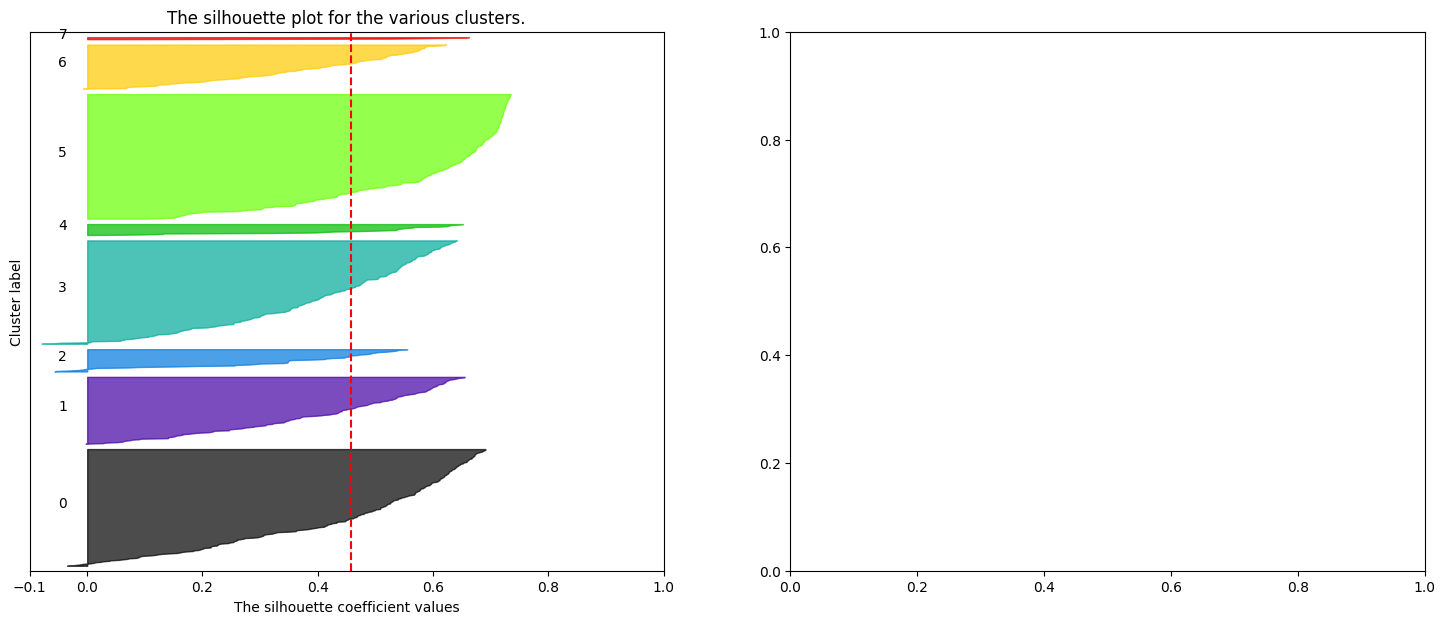

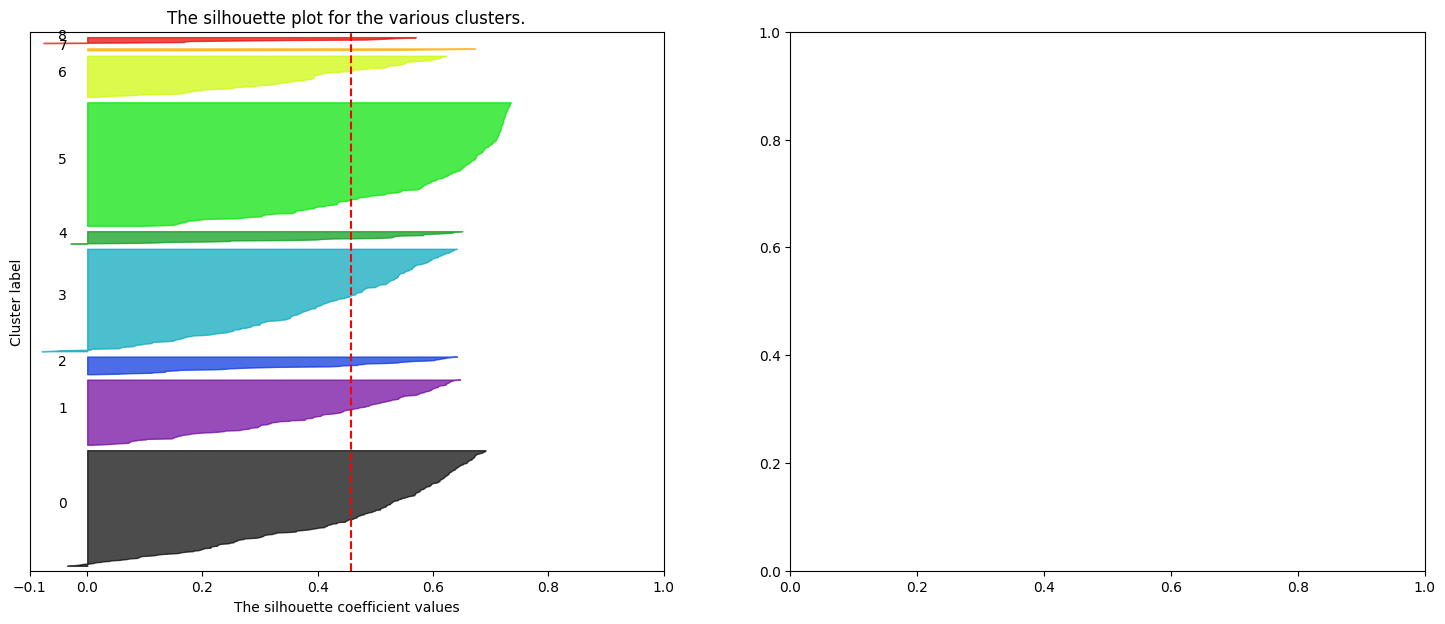

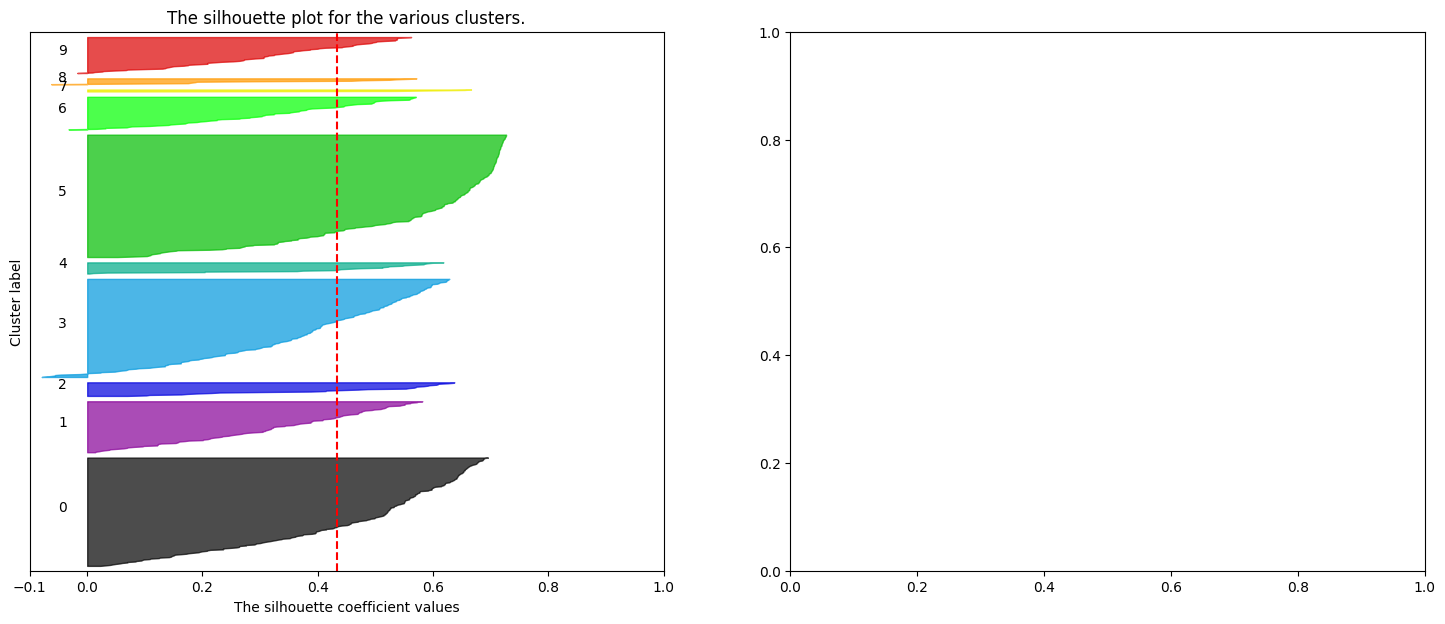

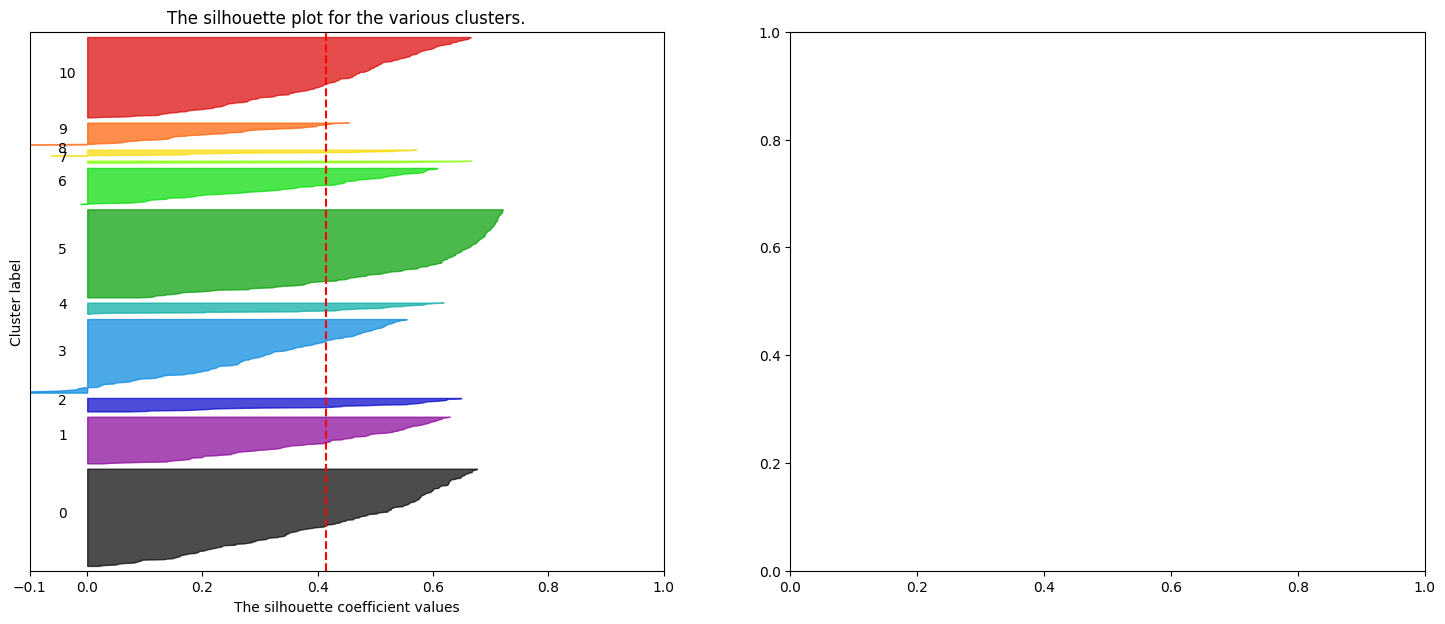

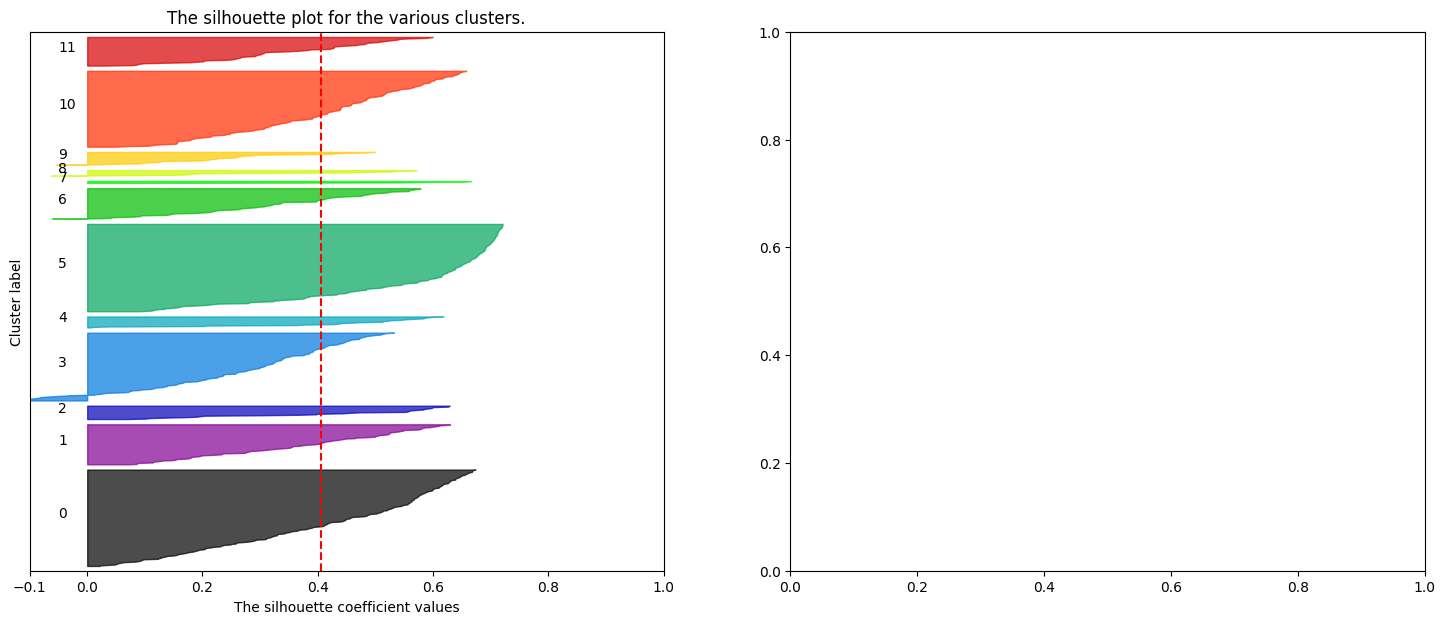

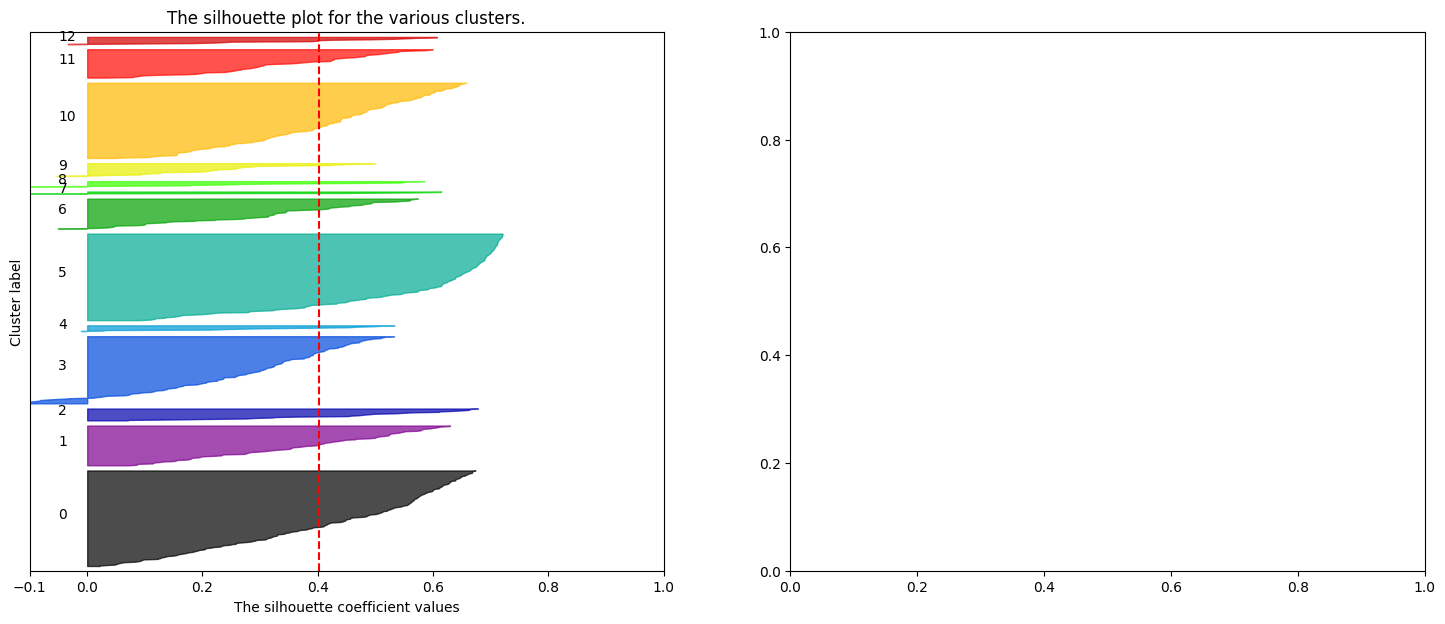

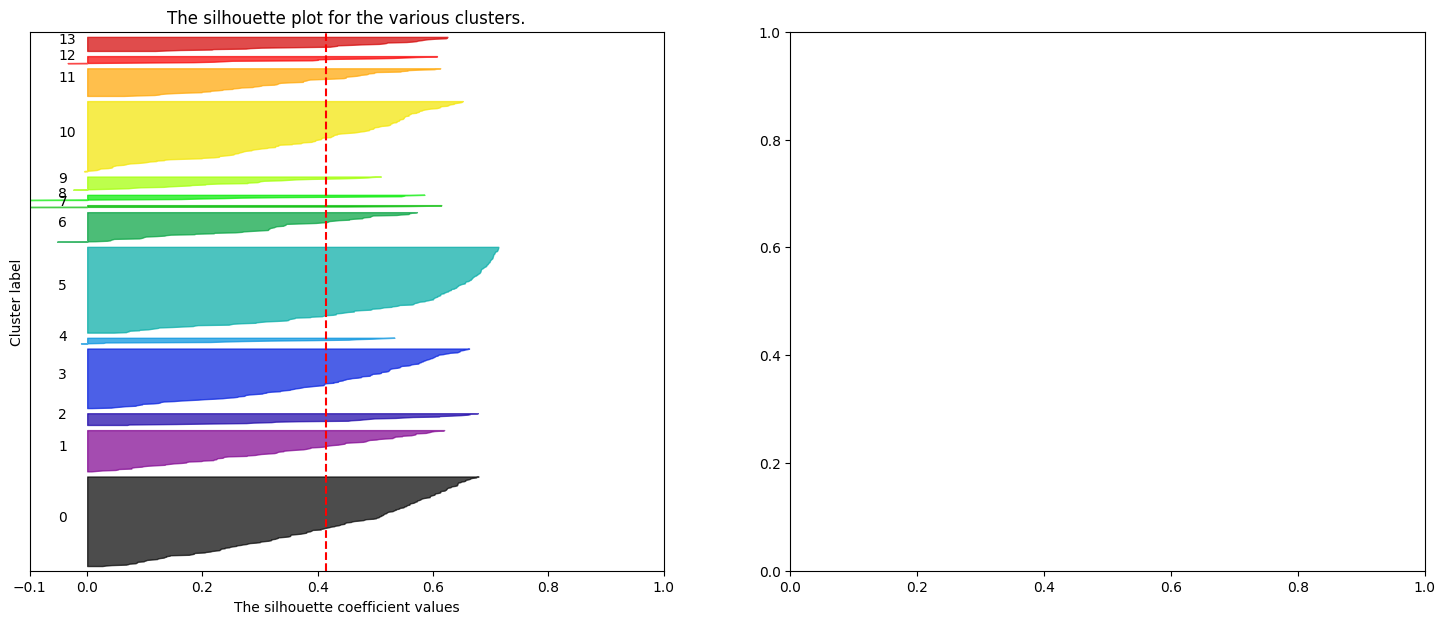

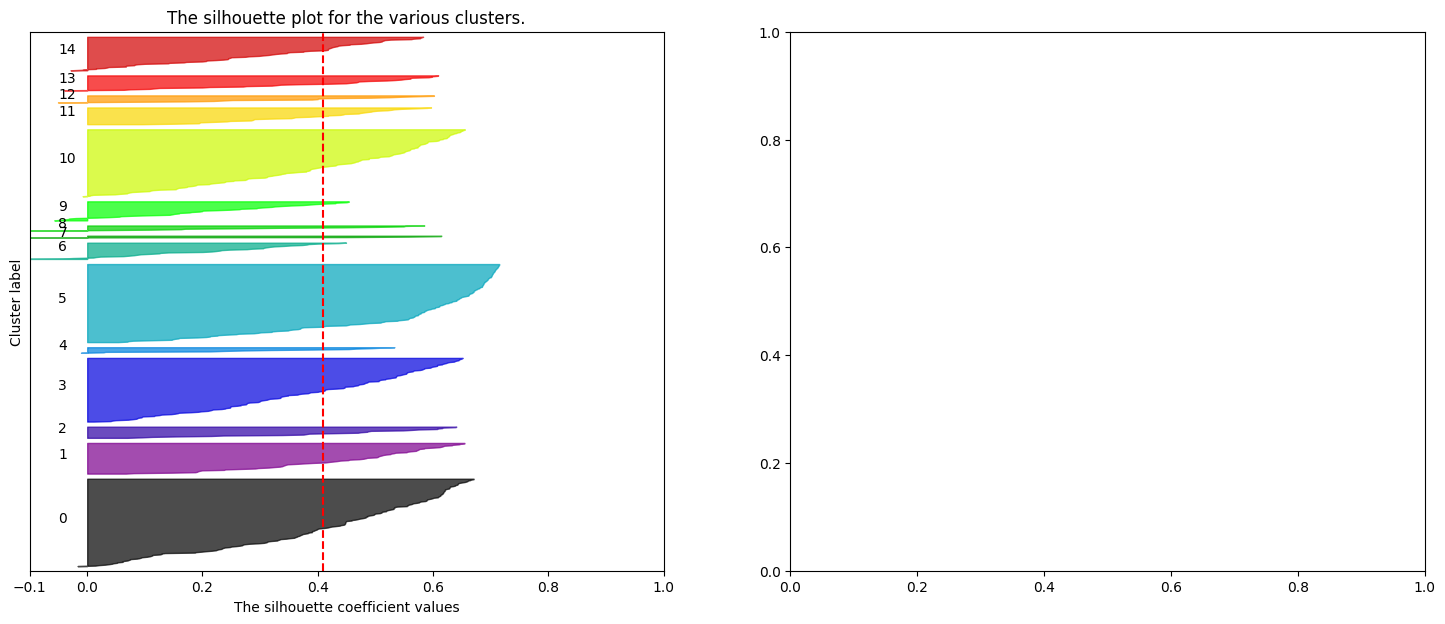

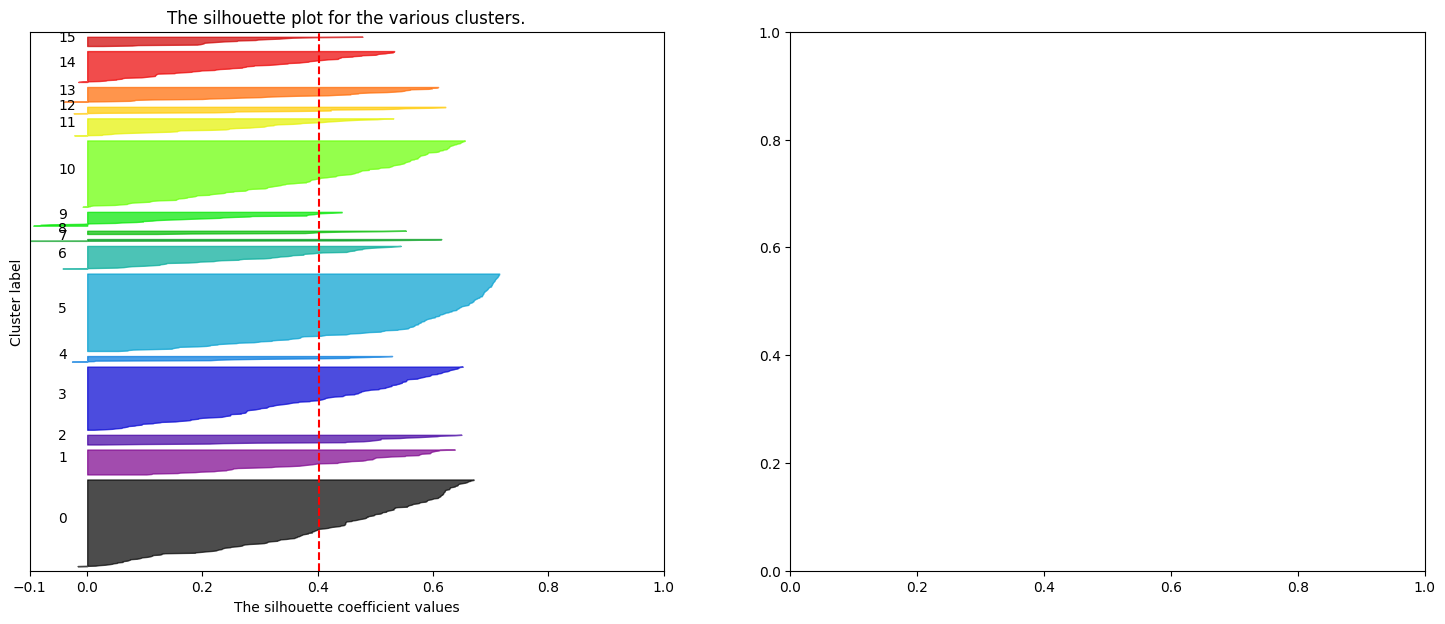

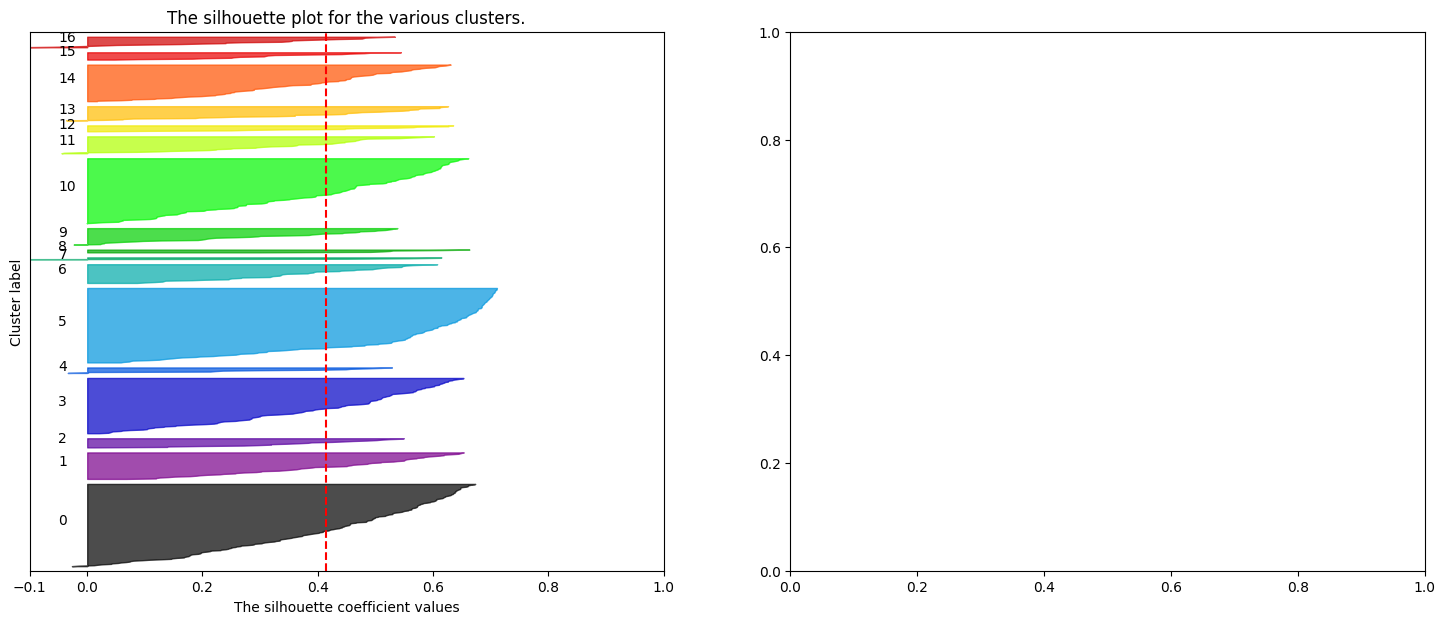

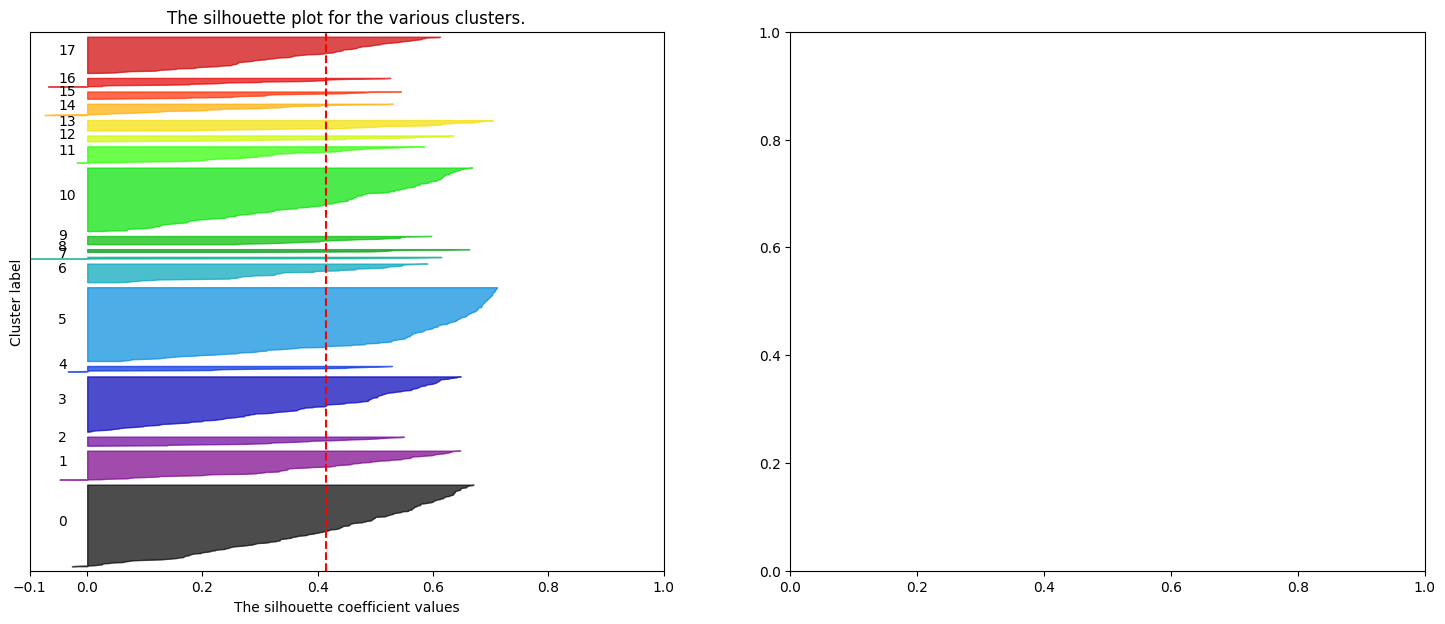

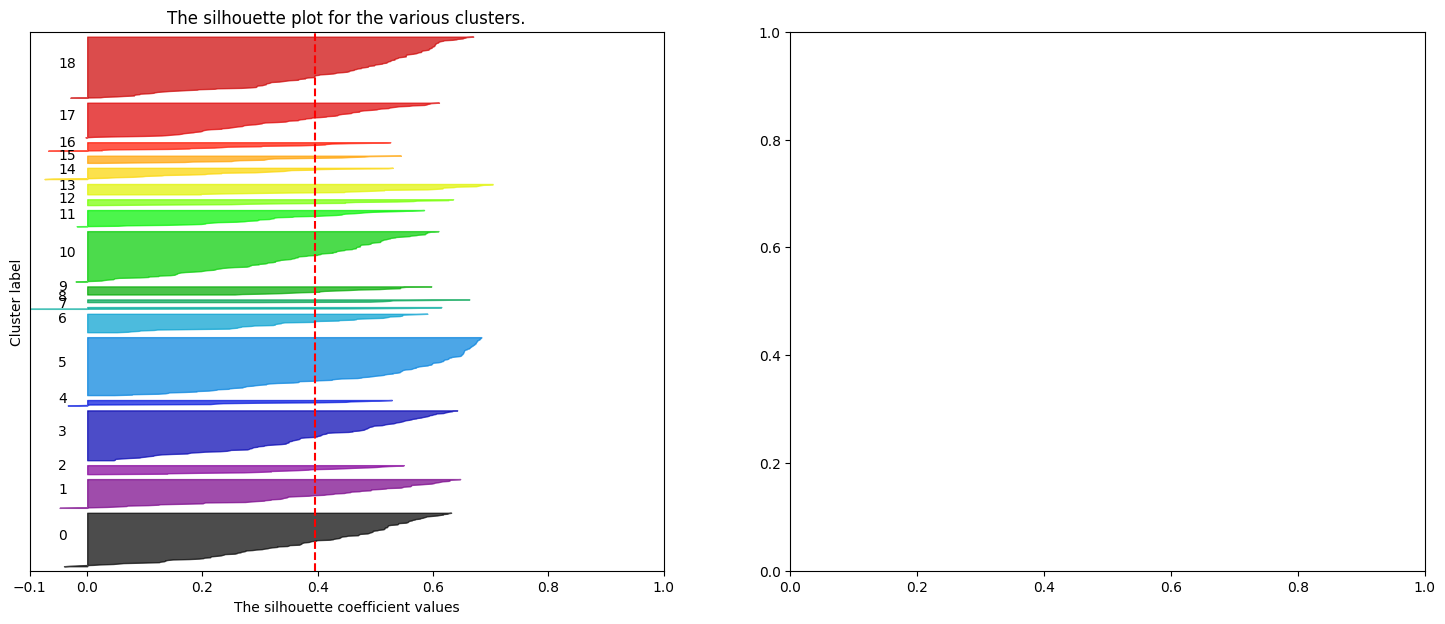

In [27]:
for n_clusters in range(2, 20):
  eval_model(KMeans(n_clusters=n_clusters, random_state=10, n_init = 'auto'), n_clusters)

For n_clusters = 8 The average silhouette_score is : 0.45754713369764805


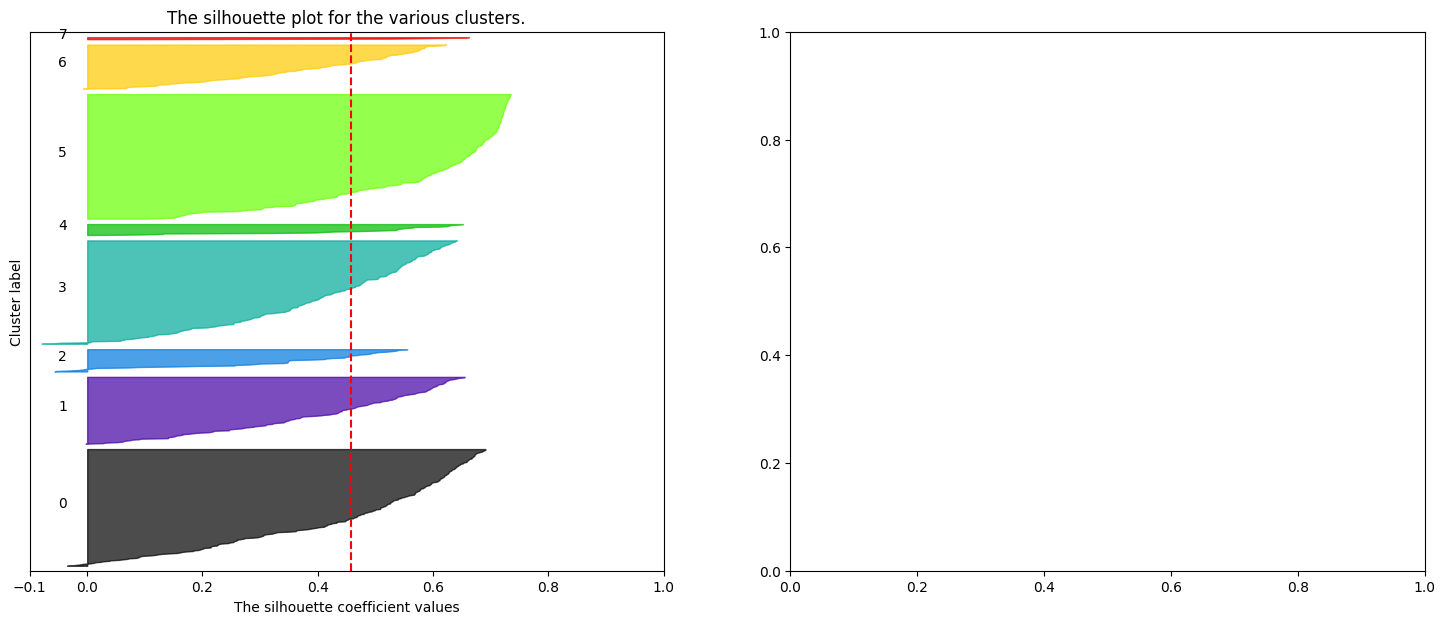

In [28]:
eval_model(KMeans(random_state=10, n_init = 'auto'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


For n_clusters = 23 The average silhouette_score is : 0.39015335990741357


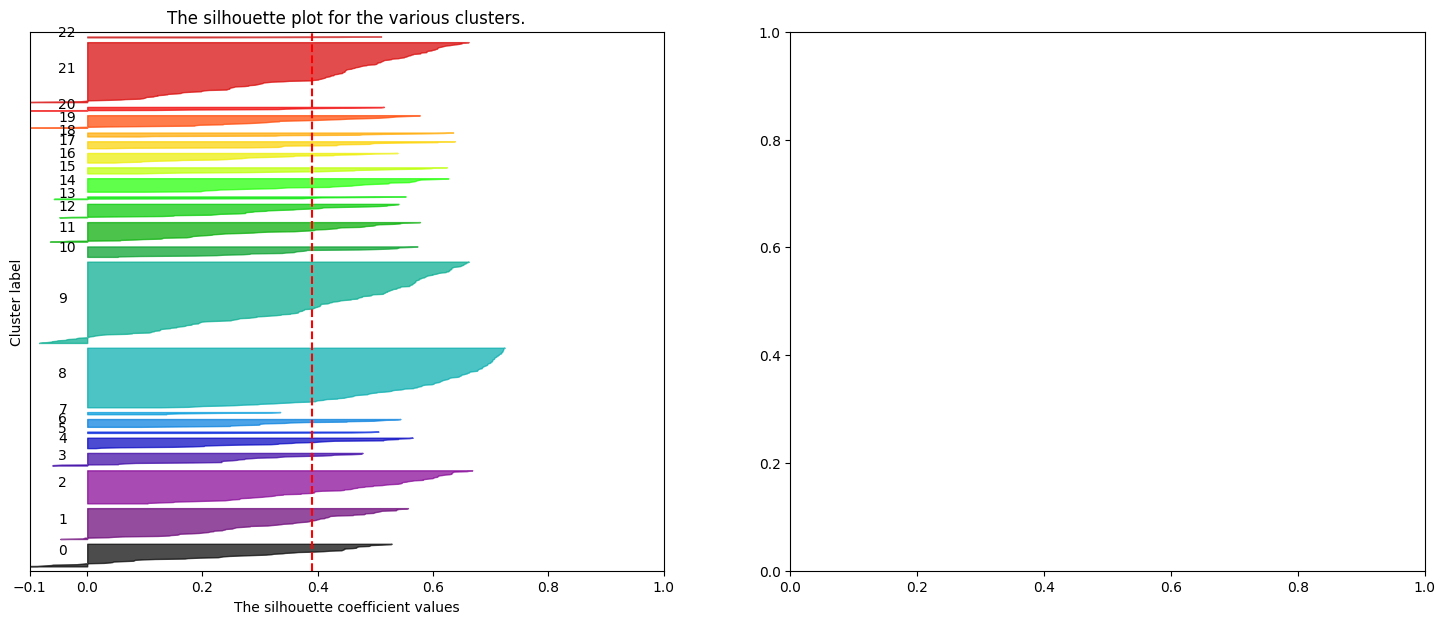

In [29]:
# for n_clusters in range(2, 10):
ap_model = AffinityPropagation(random_state=10)
eval_model(ap_model)

In [ ]:
len(np.unique(ap_model.labels_))

23

For n_clusters = 2 The average silhouette_score is : 0.37100852358350617
For n_clusters = 3 The average silhouette_score is : 0.0705079613228321
For n_clusters = 4 The average silhouette_score is : 0.11143912689895501
For n_clusters = 5 The average silhouette_score is : 0.14563042725273823
For n_clusters = 6 The average silhouette_score is : 0.1792594313108292
For n_clusters = 7 The average silhouette_score is : 0.1945237101527552
For n_clusters = 8 The average silhouette_score is : 0.19727469859377214
For n_clusters = 9 The average silhouette_score is : 0.19810256723698666


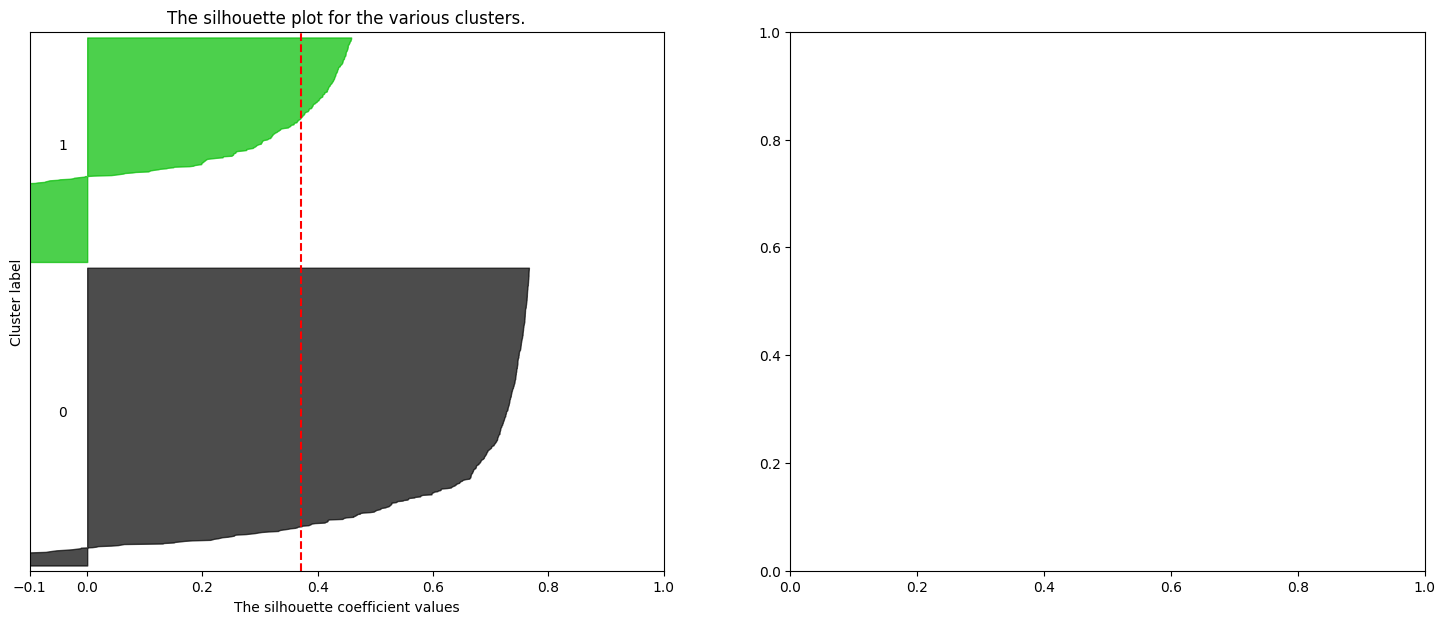

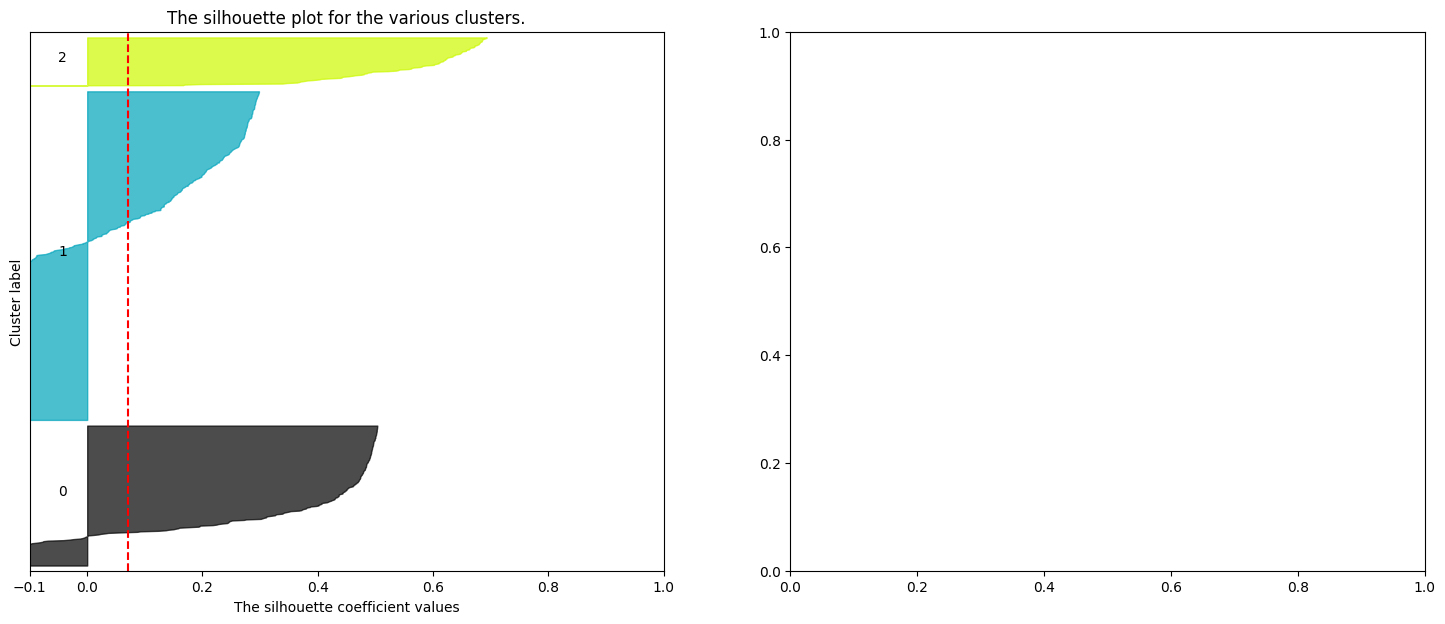

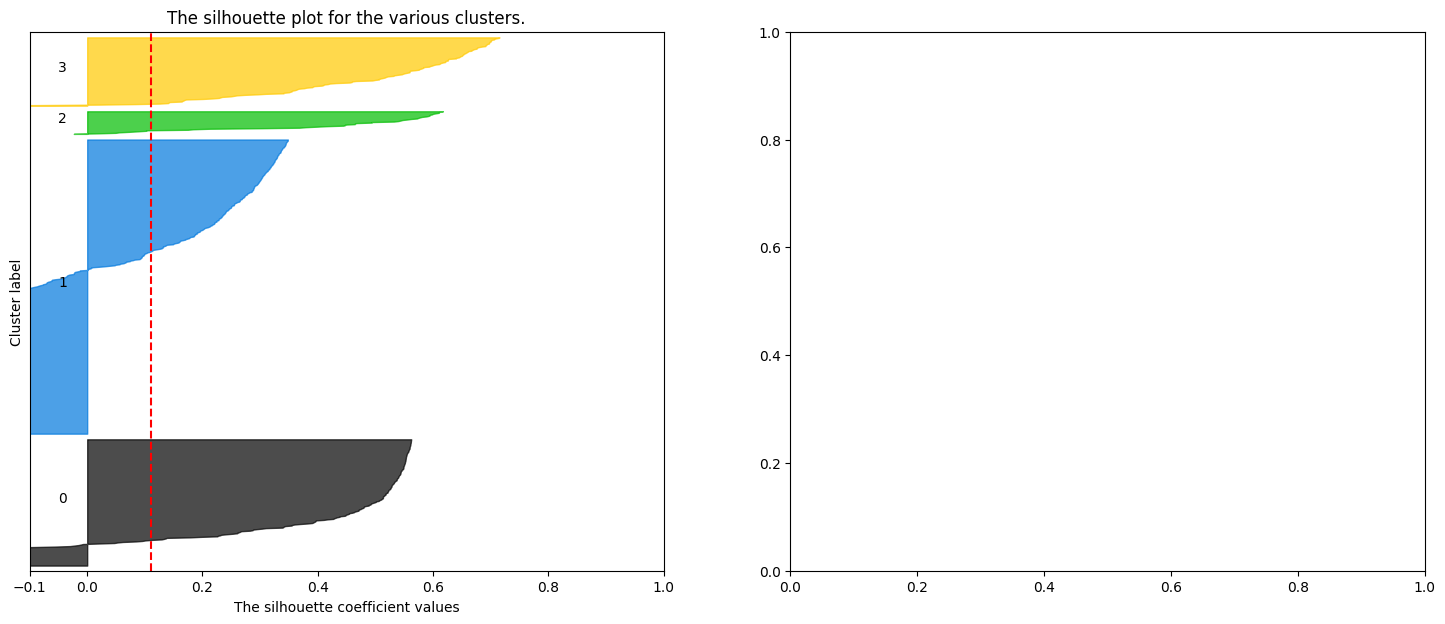

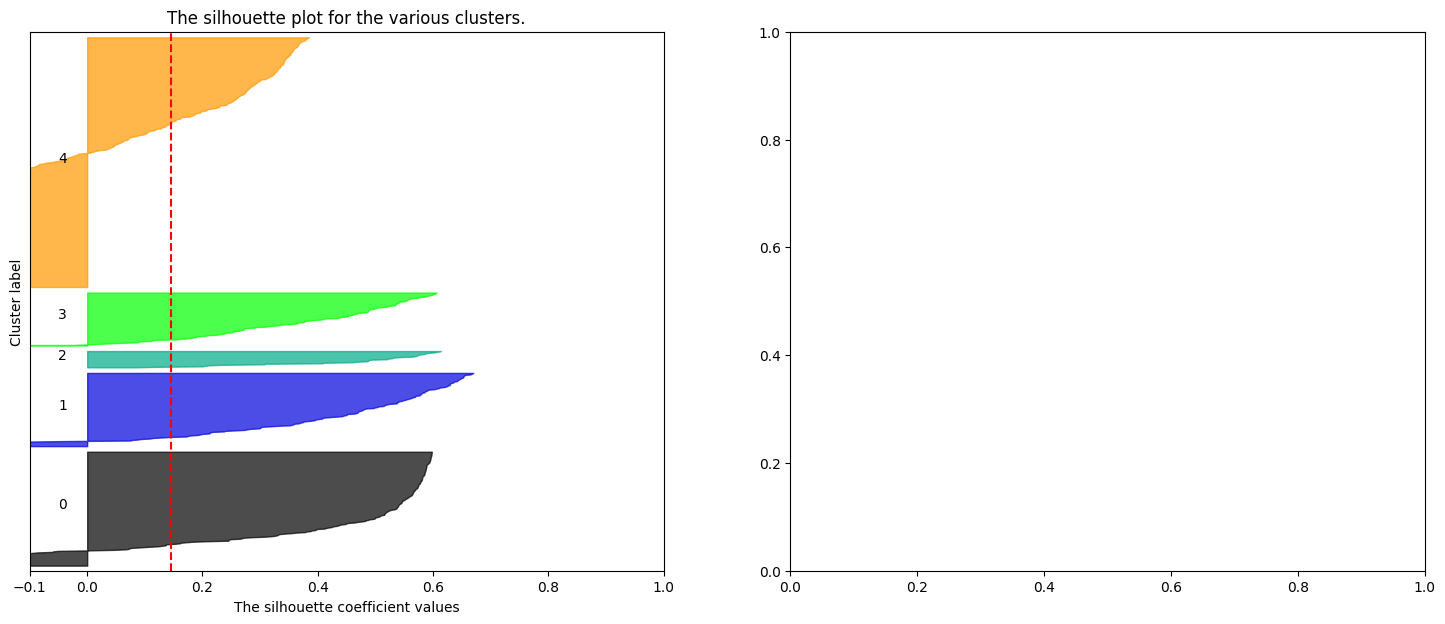

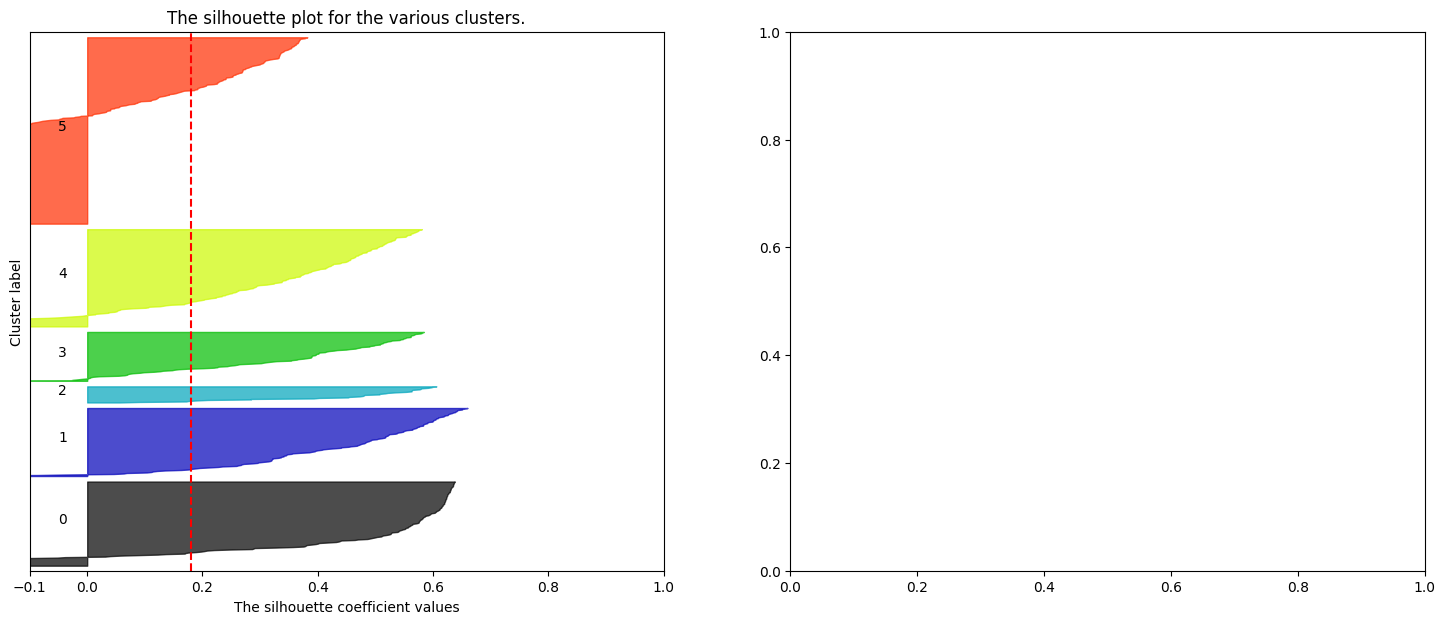

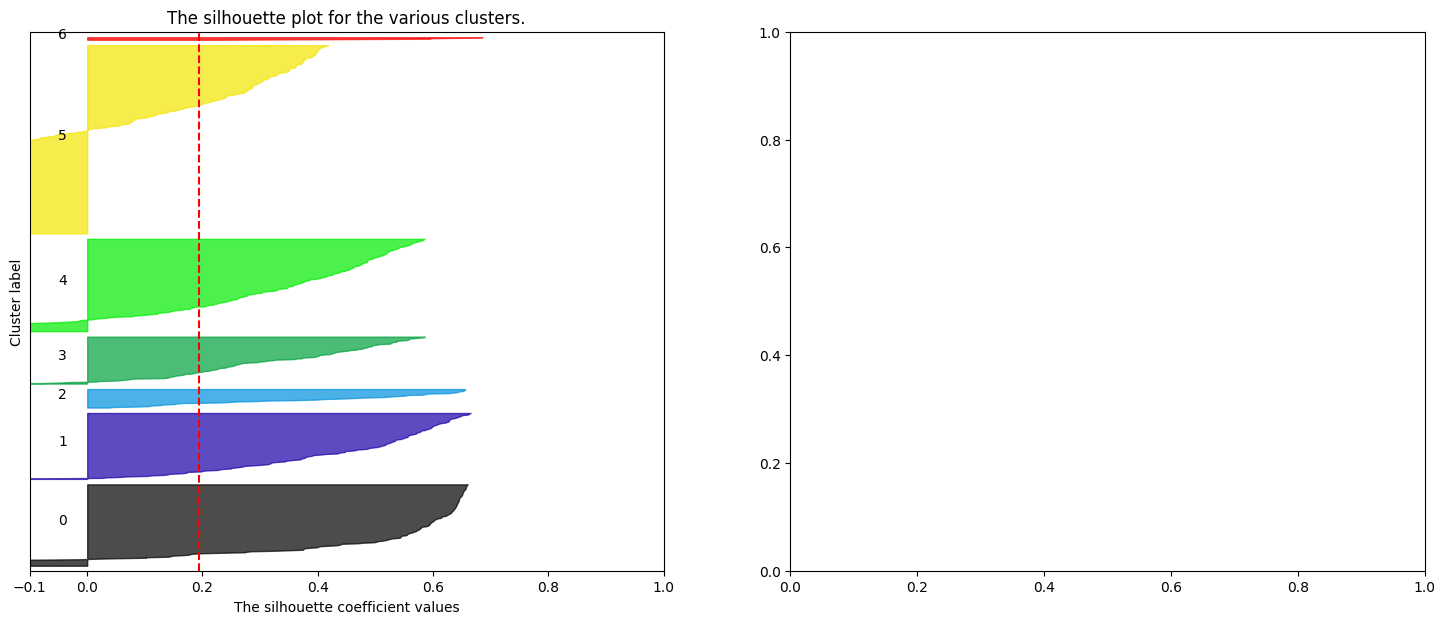

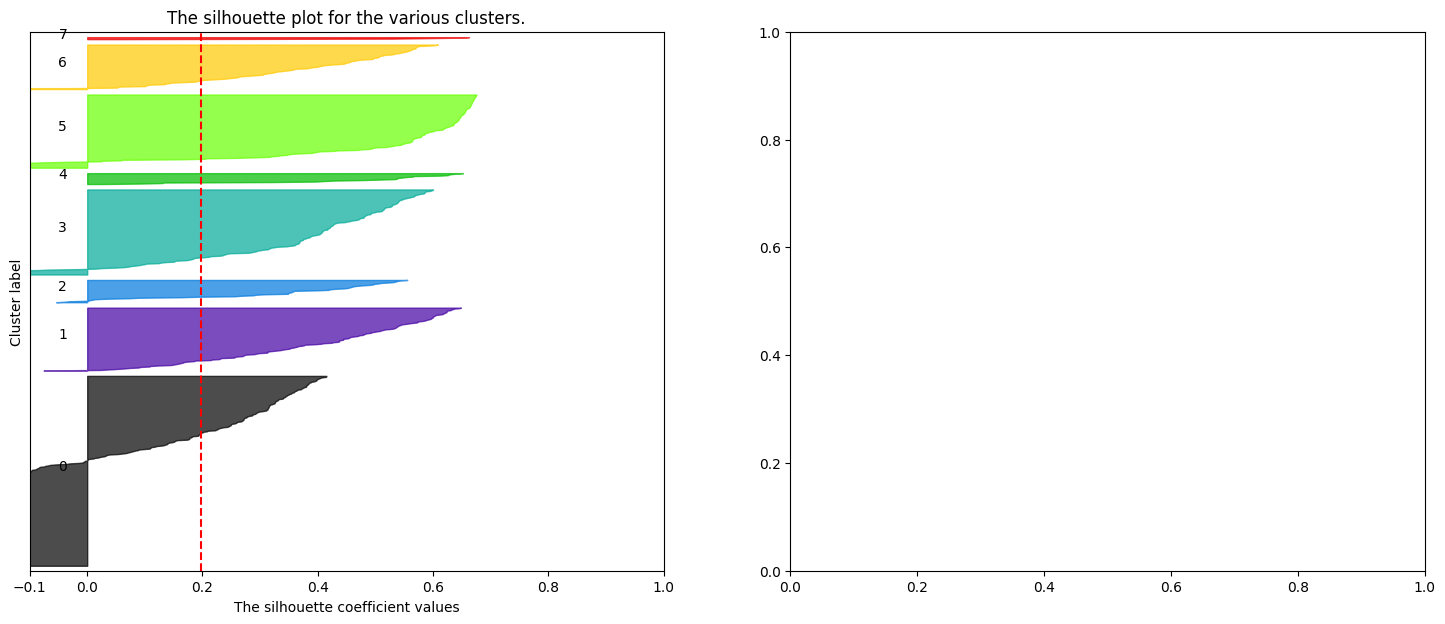

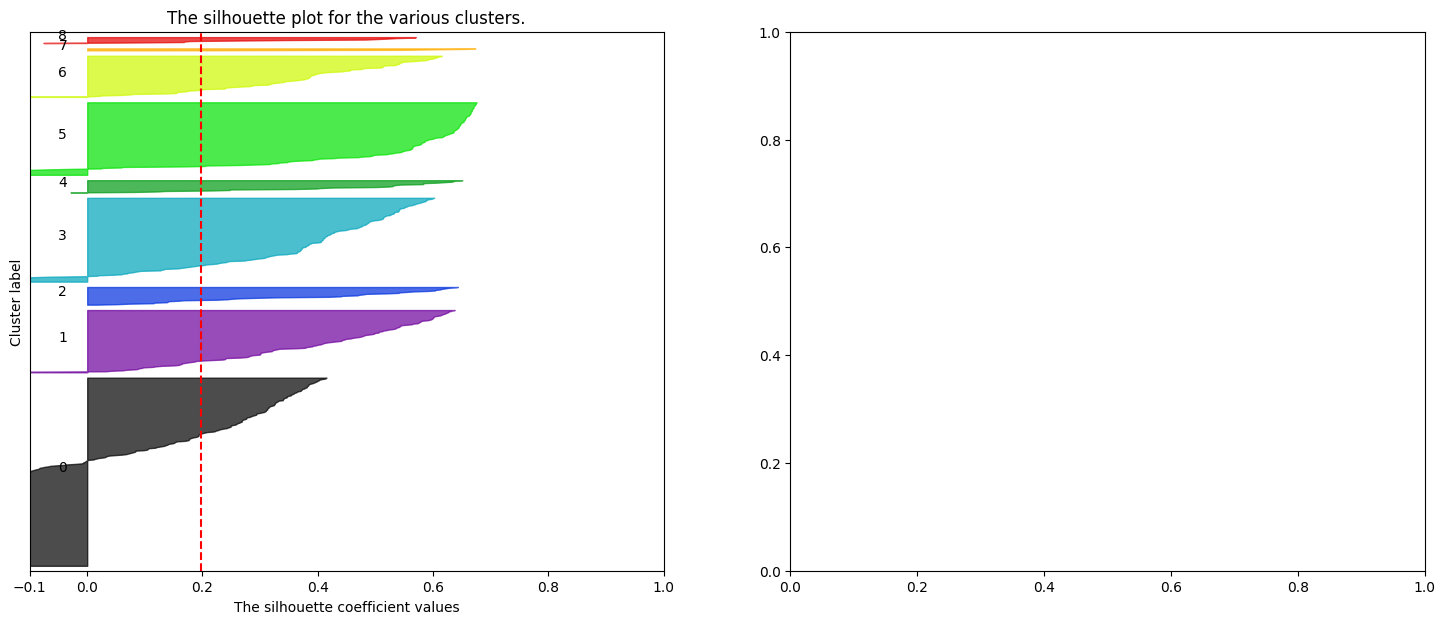

In [30]:
for n_clusters in range(2, 10):
  eval_model(GaussianMixture(n_components=n_clusters, random_state=10), n_clusters)